Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 450s 5s/step - loss: 0.6383 - accuracy: 0.6470 - val_loss: 0.4111 - val_accuracy: 0.8370
Epoch 2/30
100/100 [==============================] - 20s 198ms/step - loss: 0.4899 - accuracy: 0.7690 - val_loss: 0.3474 - val_accuracy: 0.8530
Epoch 3/30
100/100 [==============================] - 20s 200ms/step - loss: 0.4635 - accuracy: 0.7850 - val_loss: 0.3237 - val_accuracy: 0.8520
Epoch 4/30
100/100 [==============================] - 20s 201ms/step - loss: 0.4223 - accuracy: 0.8000 - val_loss: 0.3008 - val_accuracy: 0.8600
Epoch 5/30
100/100 [==============================] - 20s 201ms/step - loss: 0.4180 - accuracy: 0.7955 - val_loss: 0.3068 - val_accuracy: 0.8690
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3912 - accuracy: 0.8270 - val_loss: 0.2741 - val_accuracy: 0.8800
Epoch 7/30
100/100 [============================

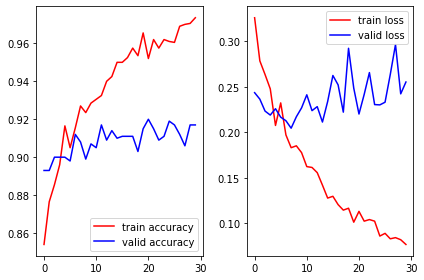

In [3]:
### 이미지 증식을 이용한 전이학습(fine tuning) ###

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/Colab임시폴더/cat_dog_small/train'
valid_dir = '/content/drive/MyDrive/Colab임시폴더/cat_dog_small/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary') # categorical(다중분류인 경우)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary') # categorical(다중분류인 경우)

# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # Convolution layer안의 parameter 동결!

# model 구현

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=1)

###### 여기까지 수행하면 classifier가 학습되요!  ######

model_base.trainable = True   # 동결이 해제되요!

for layer in model_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True   # 동결을 풀어요!
    else:
        layer.trainable = False  # 동결  

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 재학습을 진행
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=1)

### history 객체를 이용해서 결과 그래프를 그려보아요!! ###

import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()